# CSC311 Lab 3: Linear Regression

In this lab, we will complete what we started during lecture 3, and
build a linear regression model to predict the air temperature at the UTM pond
given information collected at the UTM forest.
By the end of this tutorial, you will be able to:

1. Write vectorized code using `numpy` to vectorize computation.
2. Implement gradient descent to minimize the square loss function of a linear regression model.
3. Explain the effect of the learning rate, and what happens if the learning rate is too small/too large.
4. Report model accuracy using a validation and test set.

Please work in groups of 1-2 during the tutorial.

## Acknowledgements

It's always great to work with local, UTM data!

Data is from https://www.utm.utoronto.ca/geography/resources/meteorological-station/environmental-datasets

## Submission

If you are working with a partner, start by creating a group on Markus. If you are working alone,
click "Working Alone".

Submit the ipynb file `lab03.ipynb` on Markus
**containing all your solutions to the Graded Task**s.
Your notebook file must contain your code **and outputs** where applicable,
including printed lines and images.
Your TA will not run your code for the purpose of grading.

For this lab, you should submit the following:

- Part 1. Your explanation of why splitting the data by date is better than using a random split. (1 points)
- Part 2. Your implementation of `pred` (1 points)
- Part 2. Your implementation of `grad`, along with the output of the finite difference tests (3 points)
- Part 3. Your implementation of `solve_via_gradient_descent` (1 point)
- Part 2. A reasonable hyperparameter choice and training curve for those hyperparameters (1 point)
- Part 3. Your code for sklearn to fit the linear regression model (1 point)
- Part 3. Your comparison of the results from sklearn vs our own code (1 point)
- Part 4. Your explanation for why we should not use the test set to choose between sklearn and our own model (1 point)

## Google Colab Setup

In [1]:
import matplotlib.pyplot as plt # For plotting
import numpy as np              # Linear algebra library

## Part 1. Data

Start by running these two lines of code to download the data on to Google Colab.
Recall that Google Colab allows users to run certain shell commands, and these
shell commands have a `!` at the beginning.

In [2]:
# Download tutorial data files.
!wget https://www.cs.toronto.edu/~lczhang/311/lab03/data.zip

# Unzip the zip file.
!unzip data.zip

--2025-01-24 15:17:17--  https://www.cs.toronto.edu/~lczhang/311/lab03/data.zip
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107324 (105K) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>] 104.81K   184KB/s    in 0.6s    

2025-01-24 15:17:18 (184 KB/s) - ‘data.zip’ saved [107324/107324]

Archive:  data.zip
   creating: data/
  inflating: data/data2017oct.csv    
  inflating: data/data2017sept.csv   
  inflating: data/data2016sept.csv   
  inflating: data/data2016oct.csv    


In addition to using `numpy` for its linear algebra functionalities, we will again
the `pandas` package to help us read CSV files and manipulate tabular data.
The below code reads each of the csv files into a **data frame**, which is a way that
`pandas` stores tabular data.
As an added bonus, Jupyter notebooks display these data frames in a human-readable way.

In [3]:
import pandas as pd

# read each of the csv files as a *pandas data frame*
data201609 = pd.read_csv('data/data2016sept.csv')
data201610 = pd.read_csv('data/data2016oct.csv')
data201709 = pd.read_csv('data/data2017sept.csv')
data201710 = pd.read_csv('data/data2017oct.csv')

# display one the dataframes in the notebook
data201609

,datetime,excel_datetime_code,excel_day,excel_time,field_soil_temp_c,field_air_temp_c,field_rh,field_soil_wc,forest_soil_temp_c,forest_air_temp_c,forest_rh,forest_soil_wc,pond_soil_temp_c,pond_air_temp_c,pond_rh,pond_soil_wc
0,9/1/2016 0:00,42614.00000,42614,0.000000,19.960,15.342,79.2,0.0642,19.365,17.391,75.7,0.0214,18.604,16.296,76.9,0.2472
1,9/1/2016 1:00,42614.04167,42614,0.041667,19.603,15.438,82.8,0.0642,19.199,17.034,79.3,0.0214,18.200,16.129,81.5,0.2465
2,9/1/2016 2:00,42614.08333,42614,0.083333,19.246,14.481,85.2,0.0649,19.056,16.010,81.2,0.0214,17.843,15.438,83.9,0.2465
3,9/1/2016 3:00,42614.12500,42614,0.125000,18.961,14.146,87.9,0.0649,18.913,15.461,84.5,0.0214,17.510,14.098,86.9,0.2458
4,9/1/2016 4:00,42614.16667,42614,0.166667,18.652,13.810,89.8,0.0649,18.794,15.151,86.0,0.0214,17.153,13.978,90.1,0.2458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,9/30/2016 19:00,42643.79167,42643,0.791667,15.461,15.557,78.4,0.1833,15.055,15.605,80.5,0.1419,15.533,15.772,77.8,0.2661
716,9/30/2016 20:00,42643.83333,42643,0.833333,15.342,15.366,78.5,0.1826,15.008,15.390,80.0,0.1405,15.294,15.724,77.7,0.2654
717,9/30/2016 21:00,42643.87500,42643,0.875000,15.247,14.601,78.1,0.1826,14.960,14.649,80.0,0.1397,15.079,14.960,77.3,0.2647
718,9/30/2016 22:00,42643.91667,42643,0.916667,15.151,13.906,81.7,0.1826,14.912,13.882,83.0,0.1383,14.888,14.074,80.7,0.2647


Let's also take look at how each of our individual forest features
may help predict the pond air temperature. Scatter plots
like this give us a sense of how important each of our features may be.
If you are curious about what the features mean, refer to the link given
in the Acknowledgements section earlier.

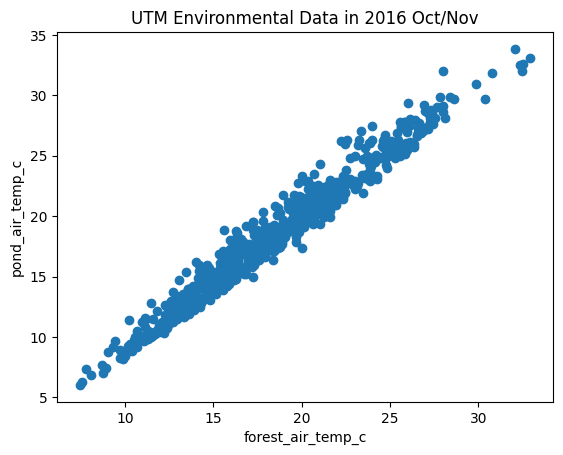

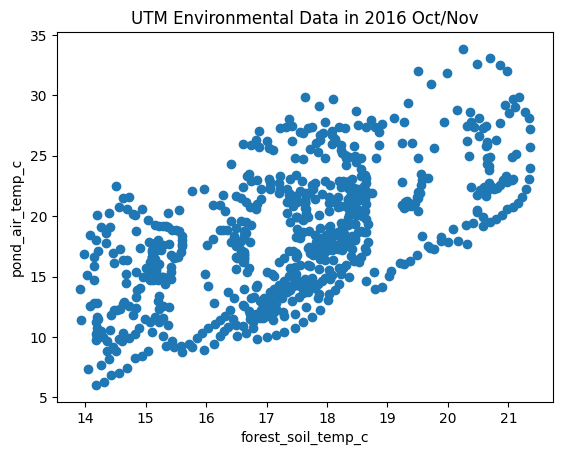

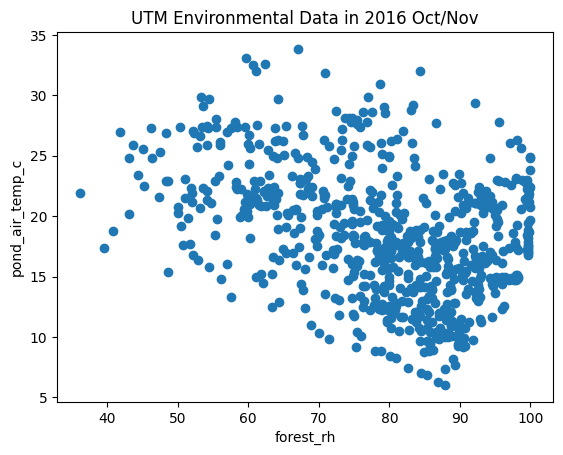

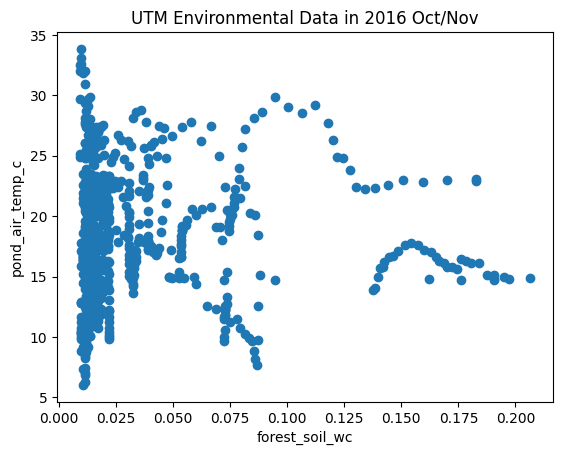

In [4]:
data_set = data201609  # change me
for fet in ["forest_air_temp_c", "forest_soil_temp_c", "forest_rh", "forest_soil_wc"]:
    plt.figure()
    X = data_set[fet]
    t = data_set["pond_air_temp_c"]
    plt.title("UTM Environmental Data in 2016 Oct/Nov")
    plt.scatter(X, t)
    plt.xlabel(fet)
    plt.ylabel("pond_air_temp_c")

### Data Splitting

We will first separate the data into training, validation, and test sets.
Rather than choosing a random percentage of data points to leave out in our
test set, we will instead place the *most recent* data points in our test set.
In particular, we will use the `201710` data as the test set, and
`201709` data as our validation set.

**Graded Task:** Explain why splitting the data by date is a better strategy
than randomly selecting data points in our test set.

**Answer**: We should not randomly split the data randomly to respect the temporal order of the data. Our goal is to predict the future based on the past observations. Providing the training set with future data will be the same as letting the model cheat and hence future predictions isn't just made from past observation but also "future observation".

Here's our code to split the training/validation/test sets:

In [5]:
train_data = pd.concat([data201609, data201610])
valid_data = data201709
test_data = data201710

print("Number of training examples:", len(train_data))
print("Number of validation examples:", len(valid_data))
print("Number of test examples:", len(test_data))

Number of training examples: 1464
Number of validation examples: 720
Number of test examples: 744


Now that we have our training set in place, our main task is to
predict the pond air temperature at UTM using the forest features.
We need to begin by building the data matrix `X` and the target vector
`t` for the training, validation, and test data.

**Task**: Complete the function `get_input_targets`, which takes a pandas dataframe.
Most of the code is written for you. `X_fets` is a numpy array of shape $N \times 4$,
where each row contains the four forest measurements.
You will need to construct the numpy array `X` of shape $N \times 5$, where
`X` has an extra column of 1's. This accounts for the bias parameter.
You may find the functions `np.ones` and `np.concatenate` helpful, but
make sure you read the documentations before using these functions.

Debugging tip: if you find this task challenging, try to keep track of
(and print out) the *shapes* of each of the quantities that you work with.

In [9]:
def get_input_targets(data):
    """
    Produces the data matrix and target vector given a dataframe `data` read
    from one of the csv files containing the UTM weather data.

    The returned data matrix should have a column of 1's, so that the bias
    parameter will be folded into the weight vector.
    """
    # extract the target vector
    t = np.array(data["pond_air_temp_c"])

    # extract the data matrix:
    X_fets = np.array(data[["forest_air_temp_c", "forest_soil_temp_c", "forest_rh", "forest_soil_wc"]]) # N x D

    n = len(data) # number of data points, you may find this information useful
    # print(np.ones(n).shape)
    X = np.concatenate((X_fets, np.ones(n).reshape(1, n).T), axis=1)
    return (X, t)

X_train, t_train = get_input_targets(train_data)
X_train

array([[1.7391e+01, 1.9365e+01, 7.5700e+01, 2.1400e-02, 1.0000e+00],
       [1.7034e+01, 1.9199e+01, 7.9300e+01, 2.1400e-02, 1.0000e+00],
       [1.6010e+01, 1.9056e+01, 8.1200e+01, 2.1400e-02, 1.0000e+00],
       ...,
       [2.3960e+00, 8.5190e+00, 8.7500e+01, 2.5700e-02, 1.0000e+00],
       [2.4500e+00, 8.4440e+00, 8.9200e+01, 2.5700e-02, 1.0000e+00],
       [3.9850e+00, 8.3690e+00, 8.9800e+01, 2.5700e-02, 1.0000e+00]])

Let's print out the shape of `X_train`, just to make sure that it is what we expect:

In [10]:
X_train.shape

(1464, 5)

When you are sure that your code works as intended, generate the validation
and test data matrices.

In [12]:
X_valid, t_valid = get_input_targets(valid_data)
X_test, t_test = get_input_targets(test_data)

print(X_valid.shape)
print(X_test.shape)

(720, 5)
(744, 5)


## Part 2. Linear Regression Model

We will be training a linear regression model using gradient descent.
Recall that a linear regression model is of the form:

$$y = f({\bf x}) = {\bf w}^T {\bf x}$$

Where $y$ is the prediction,
${\bf x}$ is a vector consisting of our features and ${\bf w}$ is a vector of the trainable weights. Note that we include the bias $b$ as the last element in the weight vector. This is
convenient since it allows us to compute $y$ using a single vector-vector multiplication; We don't need to explicitly add in the bias term after the multiplication.
Our goal is to find a good set of weights ${\bf w}$ so that $y$ will be close to $t$
across our training data. We will find these weights via gradient descent.

Before we can apply gradient descent, we need to write a few helper functions:

- `pred(w, X)`: which will compute predictions for a data set
- `mse(w, X, t)`: which will compute the mean square error cost function for a data set
- `grad(w, X, t)`: which will compute the gradient of the cost function at ${\bf w}$

Since these helper functions will be called many times, we need them to be
efficient. We will make sure that these functions are written via **vectorized**
`numpy` code. In other words, we will avoid using loops in our code, so that
`numpy` can parallelize matrix operations whenever possible.

**Graded Task:** Complete the `pred`, which produces a vector of predictions given
a set of weights ${\bf w}$ and a data matrix `X`.
Crucially, **do not use any loops**. Instead, use linear algebra
operations.

In [13]:
def pred(w, X):
    """
    Compute the prediction made by a linear hypothesis with weights `w`
    on the data set with input data matrix `X`. Recall that N is the number of
    samples and D is the number of features. The +1 accounts for the bias term.

    Parameters:
        `weight` - a numpy array of shape (D+1)
        `X` - data matrix of shape (N, D+1)
        `t` - target vector of shape (N)


    Returns: prediction vector of shape (N)
    """
    return np.matmul(X, w)

The function `mse` is written for you, and
computes the *cost* associated with a particular choice
of ${\bf w}$ across a data set. It measures how
"bad" a set of weights ${\bf w}$ is across a data set. More specifically,
it computes the average discrepancy between our predictions based on the input data ($X$) and our weights ${\bf w}$, and the true
values, or targets ($t$).

Notice that **we wrote this code without using any loops**.
Instead, we used linear algebra operations like matrix multiplication (which can be done using the `@` symbol,
or `np.matmul` or `np.dot`).
This type of vectorization technique will be key to completing the remainder
of this lab.

In [14]:
def mse(w, X, t):
    """
    Compute the mean squared error of a linear hypthesis with weights `w`
    on the data set with input data matrix `X` and targets `t`

    Parameters:
        `weight` - a numpy array of shape (D+1)
        `X` - data matrix of shape (N, D+1)
        `t` - target vector of shape (N)

    Returns: a scalar MSE value
    """
    # This function is already completed for you as an example.
    n =  X.shape[0] # the number of data points
    y = pred(w, X)  # the vector of predictions
    err = y - t
    return np.sum(err ** 2) / (2 * n) # compute the MSE in a vectorized way

**Graded Task** Now, complete the following function, which computes the
gradient of the cost function (square loss) at the weights `w`.
Once again, **do not use any loops**. Instead, use linear algebra
operations.

In [22]:
def grad(w, X, t):
    '''
    Return gradient of the cost function at `w`. The cost function
    is the average square loss (MSE) across the data set X and the
    target vector t.

    Parameters:
        `weight` - a current "guess" of what our weights should be,
                   a numpy array of shape (D+1)
        `X` - matrix of shape (N,D+1) of input features
        `t` - target y values of shape (N)

    Returns: prediction vector of shape (D+1)
    '''
    n = X.shape[0]
    # print(n)
    return np.matmul((pred(w, X) - t), X) / n #N*1 N*D+1

As we progress in this course, we will find that debugging
machine learning code can get extremely challenging.
It helps to **be systematic about testing** (follow a system),
and to test every helper function as we write it.
The `grad` function can be tricky to write, and so it helps to debug
this function carefully.

One way to debug this function is to recall the definition of a derivative.
For a function $g(w): \mathbb{R} \rightarrow \mathbb{R}$,

$$g'(w) = \lim_{h \rightarrow 0} \frac{g(w+h) - g(w)}{h}$$

This above rule tells us that if we have a way to evaluate `g` and would like to
test our implementation of $g'$, we can choose an $h$ small enough, and check if:

$$g'(w) \approx \frac{g(w+h) - g(w)}{h}$$

In our case, we have that for an $h$ small enough, we should have:

$$\frac{\partial \textrm{MSE}}{\partial w_j} \approx \frac{\textrm{MSE}(w_0, w_1, \dots, w_{j-1}, w_j + h, w_{j+1}, \dots, w_D) - \textrm{MSE}(w_0, w_1, \dots, w_D)}{h}$$

**Graded Task:** We will use this above finite difference rule to check our implementation
of the `grad` function. Consider the values ${\bf w} = {\bf 1}$, where every weight is set to 1.
Check, for each of $w_j$, that `grad(w, X_train, t_train)[j]` is close to `(mse(perturbed_w, X_train, t_train) - mse(w, X_train, t_train)) / h`,
where `perturbed_w` is a copy of the vector `w` but with the j-th element perturbed by `h`.

In [26]:
h = 0.0001  # a reasonably small value of "h"
w = np.ones(5)   # a vector of weights
for j in [0, 1, 2, 3, 4]:
    perturbed_w = np.copy(w)  # start by making a copy of w

    # TODO: perturb the jth element of perturbed_w by h
    perturbed_w[j] += h
    # Be extremely careful that only the j-th element is perturbed!

    estimate = (mse(perturbed_w, X_train, t_train) - mse(w, X_train, t_train)) / h

    func_call = grad(w, X_train, t_train)[j]

    print("Grading Checking for weight j=", j)
    print("grad(w)[j]", func_call)
    print("(mse(perturbed_w) - mse(w)) / h = ", estimate)
    print('Value diff = ', abs(func_call-estimate))

Grading Checking for weight j= 0
grad(w)[j] 1446.5196269508883
(mse(perturbed_w) - mse(w)) / h =  1446.5325991022837
Value diff =  0.01297215139538821
Grading Checking for weight j= 1
grad(w)[j] 1471.0863061040986
(mse(perturbed_w) - mse(w)) / h =  1471.0980375730287
Value diff =  0.011731468930065603
Grading Checking for weight j= 2
grad(w)[j] 8150.429990259561
(mse(perturbed_w) - mse(w)) / h =  8150.772268172659
Value diff =  0.3422779130978597
Grading Checking for weight j= 3
grad(w)[j] 4.915506874487706
(mse(perturbed_w) - mse(w)) / h =  4.915507088298909
Value diff =  2.1381120340890902e-07
Grading Checking for weight j= 4
grad(w)[j] 97.69412588797816
(mse(perturbed_w) - mse(w)) / h =  97.6941758835892
Value diff =  4.9995611036024457e-05


**Task** To test our `grad` function more thoroughly, you may wish to repeat the above experiment with different values of ${\bf w}$,
${\bf X}$ and ${\bf t}$.

In [27]:
h = 0.0000001  # a reasonably small value of "h"
w = np.ones(5)   # a vector of weights
for j in [0, 1, 2, 3, 4]:
    perturbed_w = np.copy(w)  # start by making a copy of w

    # TODO: perturb the jth element of perturbed_w by h
    perturbed_w[j] += h
    # Be extremely careful that only the j-th element is perturbed!

    estimate = (mse(perturbed_w, X_train, t_train) - mse(w, X_train, t_train)) / h

    func_call = grad(w, X_train, t_train)[j]

    print("Grading Checking for weight j=", j)
    print("grad(w)[j]", func_call)
    print("(mse(perturbed_w) - mse(w)) / h = ", estimate)
    print('Value diff = ', abs(func_call-estimate))

Grading Checking for weight j= 0
grad(w)[j] 1446.5196269508883
(mse(perturbed_w) - mse(w)) / h =  1446.5196363744326
Value diff =  9.423544270248385e-06
Grading Checking for weight j= 1
grad(w)[j] 1471.0863061040986
(mse(perturbed_w) - mse(w)) / h =  1471.0863069922198
Value diff =  8.881211215339135e-07
Grading Checking for weight j= 2
grad(w)[j] 8150.429990259561
(mse(perturbed_w) - mse(w)) / h =  8150.430330715608
Value diff =  0.00034045604661514517
Grading Checking for weight j= 3
grad(w)[j] 4.915506874487706
(mse(perturbed_w) - mse(w)) / h =  4.915500539937057
Value diff =  6.334550649356174e-06
Grading Checking for weight j= 4
grad(w)[j] 97.69412588797816
(mse(perturbed_w) - mse(w)) / h =  97.69411917659454
Value diff =  6.711383619517619e-06


Once you are satisfied that your `grad` functions works as intended, we are ready to implement
gradient descent.

**Graded Task** Complete the function `solve_via_gradient_descent`, as per the specification below.

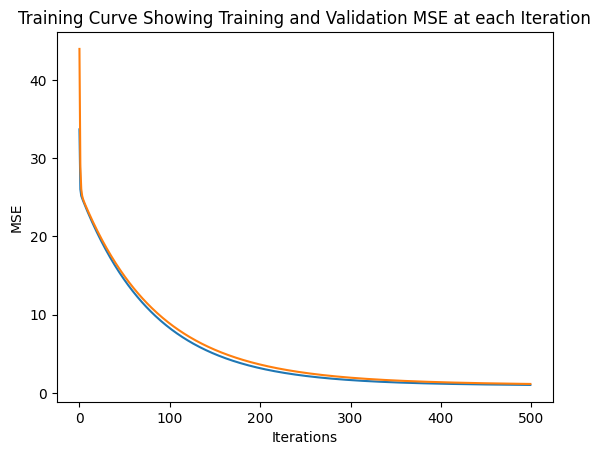

Final Training MSE: 1.0191403985281207
Final Validation MSE: 1.143630319171339


array([ 8.15195346e-01,  3.32516888e-01, -2.67196155e-02,  3.00069190e-04,
        7.96425541e-03])

In [28]:
def solve_via_gradient_descent(alpha=0.0025, niter=1000,
                               X_train=X_train, t_train=t_train,
                               X_valid=X_valid, t_valid=t_valid,
                               w_init=None):
    '''
    Given `alpha` - the learning rate
          `niter` - the number of iterations of gradient descent to run
          `X_train` - the data matrix to use for training
          `t_train` - the target vector to use for training
          `X_valid` - the data matrix to use for validation
          `t_valid` - the target vector to use for validation
          `w_init` - the initial `w` vector (if `None`, use a vector of all zeros)
    Solves for linear regression weights.
    Return weights after `niter` iterations.
    '''
    # initialize all the weights to zeros
    w = np.zeros(X_train.shape[1])

    # we will track the MSE value at each iteration to record progress
    train_mses = []
    valid_mses = []

    for it in range(niter):
        # TODO: update `w` using the gradient descent update rule
        w -= alpha * grad(w, X_train, t_train)
        # Record the current training and validation MSE values
        # Note that in practice, it is expensive to compute MSE at
        # every iteration, and practitioners will typically compute cost
        # every few iterations instead (e.g. every ~10, 100 or 1000 iterations,
        # depending on the learning task)
        train_mses.append(mse(w, X_train, t_train))
        valid_mses.append(mse(w, X_valid, t_valid))

    plt.title("Training Curve Showing Training and Validation MSE at each Iteration")
    plt.plot(train_mses, label="Training MSE")
    plt.plot(valid_mses, label="Validation MSE")
    plt.xlabel("Iterations")
    plt.ylabel("MSE")
    plt.show()

    print("Final Training MSE:", train_mses[-1])
    print("Final Validation MSE:", valid_mses[-1])

    return w

solve_via_gradient_descent(alpha=0.0001, niter=500)

**Task** Show an example of a learning rate that is too low (makes little progress). Do this by calling `solve_via_gradient_descent()` with your chosen learning rate and number of iterations.

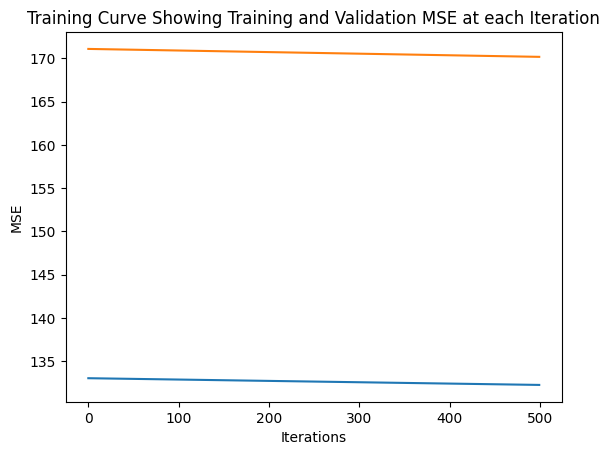

Final Training MSE: 132.26499135621378
Final Validation MSE: 170.17575261864943


array([1.30909294e-04, 1.19851405e-04, 5.97573980e-04, 3.59760486e-07,
       7.43610062e-06])

In [30]:
solve_via_gradient_descent(alpha=0.000000001, niter=500)

**Task** Show an example of a learning rate that is too high (cost does not decrease at all). Do this by calling `solve_via_gradient_descent()` with your chosen learning rate and number of iterations.

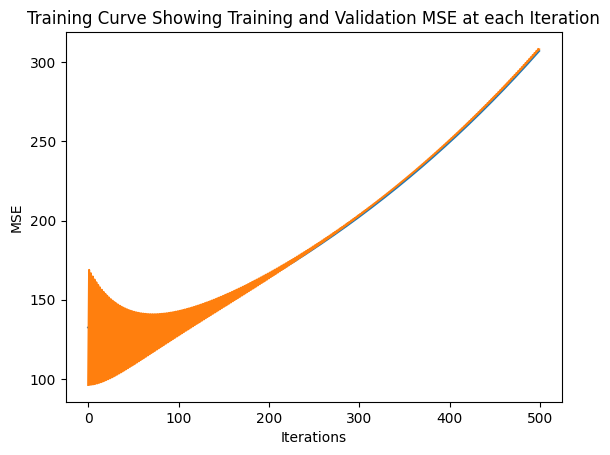

Final Training MSE: 307.08618596773886
Final Validation MSE: 308.1145855898


array([ 0.86304088,  0.18495107, -0.30784904,  0.00098429,  0.0039111 ])

In [43]:
solve_via_gradient_descent(alpha=0.000275, niter=500)

**Graded Task** At what learning rate and training iteration do you think we should stop training?
Choose a learning rate and `niter` setting that minimizes the **validation MSE**.
Here, we are treating the `niter` and `alpha` settings as **hyperparamters**.

**Answer** : as long as the value of alpha is equal of less than 0.00025, with sufficient number of iterations, the model will converge given that we use the UTM environmental dataset.

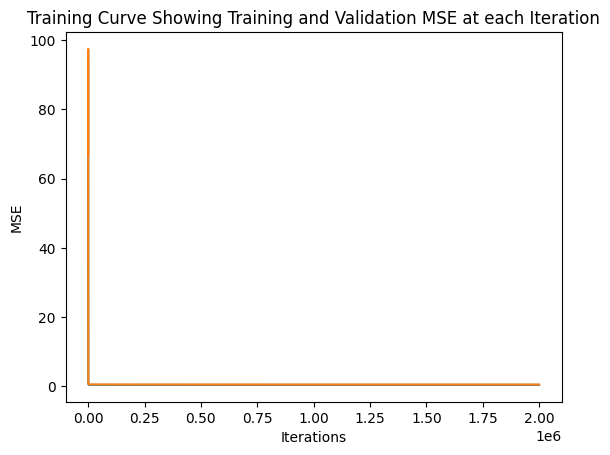

Final Training MSE: 0.42032207353456424
Final Validation MSE: 0.5346274575232594


In [59]:
alpha = 0.00025 # TODO: choose your own value
niter = 2000000    # TODO: choose your own value
best_w = solve_via_gradient_descent(alpha=alpha, niter=niter)

## Part 3. Linear Regression via `sklearn`

In practise, machine learning practitioners rarely code models from scratch.
Instead, we use libraries where commonly used model and code are already written
and optimized for us.

**Graded Task**: Fit the `LinearRegression` model below using our data set. You will need
to read the documentation for the `sklearn.linear_model.LinearRegression` class
to do so: [https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

In [60]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression(fit_intercept=False)

# TODO: fit the model
lr.fit(X_train, t_train)
print(lr.coef_) # weights
print("Training MSE:", mse(lr.coef_ , X_train, t_train))
print("Validation MSE:", mse(lr.coef_ , X_valid, t_valid))

[ 1.14569907e+00 -2.22262332e-01 -4.49208315e-04  2.61061154e+00
  1.13147146e+00]
Training MSE: 0.4191865335462788
Validation MSE: 0.530175642791847


**Graded Task**: Compare your results with these ones. Do you get the same results?
Does sklearn's result give a higher or lower training MSE than yours?
What about validation MSE?

**Answer** : sklearn gave a lower MSE on both the training data and the validation data

## Part 4. Reporting Test Accuracy

**Graded Task**: Compare your best weights (in terms of validation MSE) from Parts 2 and 3.
How should you choose which model to use? Why is it a **bad idea** to use the test set to
make this decision?

**Answer**: We would want a model with lower MSE since it gives more accurate predictions.
Using the test set to make the decision would be the same as using future data
to predict the future. This is not ideal since we won't be able to retrieve
data from the future.

Choose a single best hypothesis from Parts 3 and 4.
Reporting the test accuracy on this model.

In [65]:
# We'll use sklearn's weights, here is the test accuracy.
our_model_mse = mse(best_w, X_test, t_test)
sklearn_model_mse = mse(lr.coef_ , X_test, t_test)
if our_model_mse > sklearn_model_mse:
    print("SKlearn has better accuracy than our model")
    print("Sklearn Test MSE:", sklearn_model_mse)
else:
    print("Our model has better accuracy than sklearn")
    print("Our model test MSE", our_model_mse)

SKlearn has better accuracy than our model
Sklearn Test MSE: 0.6198683430965538
